In [ ]:
import pandas as pd
#import pandas_datareader as pdr
import requests
import eurostat
import pyreadr

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload


from helper import (get_regions, get_emu_regions, eu, Eurozone, non_tradable_sectors, tradable_sectors)
eurozone = Eurozone()

In [114]:
import helper
reload(helper)
from helper import (currency_country_map, Eurozone, non_tradable_sectors, tradable_sectors, get_emu_regions)

### EU-KLEMS: More detailed analysis - getting absolute values of ULC
#### Goal: get ULC by own calculation and also on a sectoral level
#### variables description: https://www.dropbox.com/s/ziu7wpl8pgqhq51/Variable%20List.xlsx?dl=0
#### KLEMS main website: https://euklems.eu/query/
#### The 2019 KLEMS release: https://euklems-intanprod-llee.luiss.it/download/
#### New KLEMS seems to refer to Nama_10_a64 : https://euklems.eu/wp-content/uploads/2023/01/wiiw-GPD_Release2023.pdf
#### TODO check and compare: https://ec.europa.eu/eurostat/databrowser/view/nama_10_lp_ulc/default/table?lang=en

In [3]:
# old version of KLEMS (not sure which one but it ends in 2019, so I call it 2019)
# NOTE: here for rerefence and checking, but not actively used
klems_na = pyreadr.read_r("national accounts.rds")[None]
klems_na = klems_na.astype({"year": int})
klems_na = get_regions(klems_na, 'geo_code')

klems_na.head()

,nace_r2_code,geo_code,nace_r2_name,geo_name,year,COMP,EMP,EMPE,GO_CP,GO_PI,...,H_EMPE,II_CP,II_PI,II_PYP,II_Q,VA_CP,VA_PI,VA_PYP,VA_Q,region
0,A,AT,"Agriculture, forestry and fishing",Austria,1995,363.7,273.10,20.59,7656.1,92.326044,...,39192.0,3843.9,74.985756,4168.299699,5126.173576,3812.3,116.708,3917.4,3266.528430,DE_AT
1,A,AT,"Agriculture, forestry and fishing",Austria,1996,369.6,260.92,20.40,7485.4,89.203056,...,38589.0,3866.6,73.638100,3937.362930,5250.814488,3618.8,110.849,3810.1,3264.621242,DE_AT
2,A,AT,"Agriculture, forestry and fishing",Austria,1997,380.5,254.58,20.88,7632.7,89.326044,...,39008.0,4036.6,74.460979,3991.990935,5421.094460,3596.1,109.807,3630.2,3274.927828,DE_AT
3,A,AT,"Agriculture, forestry and fishing",Austria,1998,382.0,244.97,20.28,7414.2,85.778455,...,38325.0,3893.0,73.579585,3939.633414,5290.869760,3521.2,102.255,3781.2,3443.547993,DE_AT
4,A,AT,"Agriculture, forestry and fishing",Austria,1999,398.4,240.43,20.74,7385.2,83.380806,...,39831.0,3874.4,73.007411,3904.764431,5306.858477,3510.8,97.215,3692.8,3611.376845,DE_AT


In [7]:
klems_k = pyreadr.read_r("capital accounts.rds")[None]

klems_k = klems_k.astype({"year": int})
klems_k = get_regions(klems_k, 'geo_code')

klems_k.head()

,nace_r2_code,geo_code,nace_r2_name,geo_name,year,I_CT,I_Cult,I_GFCF,I_IT,I_OCon,...,Kq_GFCF,Kq_IT,Kq_OCon,Kq_OIPP,Kq_OMach,Kq_RD,Kq_Rstruc,Kq_Soft_DB,Kq_TraEq,region
0,A,AT,"Agriculture, forestry and fishing",Austria,1995,2.000000e-01,147.0,1.537200e+03,7.000000,710.700000,...,3.714832e+04,31.798800,28760.874080,0.0,4.627605e+03,6.340139,0.0,8.817073,2559.156073,DE_AT
1,A,FR,"Agriculture, forestry and fishing",France,2010,0.000000e+00,843.0,1.067600e+04,56.000000,2933.000000,...,1.224205e+05,77.673045,44134.391200,0.0,5.003525e+04,1269.757335,0.0,53.132143,2292.969415,west
2,A,JP,"Agriculture, forestry and fishing",Japan,2012,-1.692053e+09,138600.0,1.512191e+06,8118.879661,264555.504919,...,2.031490e+06,8514.871088,619929.129812,0.0,1.054258e+06,17882.657041,0.0,52628.276058,165777.927868,rest
3,A,DE,"Agriculture, forestry and fishing",Germany (until 1990 former territory of the FRG),1997,4.132000e+01,109.0,6.076000e+03,35.130000,1856.000000,...,1.646978e+05,29.058944,112981.953671,0.0,3.947248e+04,587.774887,0.0,59.000000,1461.294026,DE_AT
4,A,NL,"Agriculture, forestry and fishing",Netherlands,2014,3.000000e+00,333.0,5.164000e+03,21.000000,2342.000000,...,5.219788e+04,61.090909,35532.060165,0.0,1.163074e+04,933.603859,0.0,118.813953,1575.861199,west


In [ ]:
# Markups - Piton's mu = sector specific time varying markups, or only time-varying markups

### Getting Eurostat data

- Original loads - DO NOT RUN

In [ ]:
## Downloading the data from Eurostat - this is due to the changes in the most recent KLEMS format
## The values for the relevant variables are the same as from the EU-KLEMS data above, but containing 2019-2022 data.
## First I get the Value added 
# NOTE: downloaded and save below on Dec 13, 2023, NO NEED TO RUN IT AGAIN!
nama_a10_a64 = eurostat.get_data_df("nama_10_a64").rename(columns={"geo\\time": "Country"})
nama_a10_a64 = nama_a10_a64.loc[np.where((
                                      (nama_a10_a64['unit'] == "CP_MNAC") &
                                      (nama_a10_a64['na_item'].isin(["B1G", "D1"])) # BG1 = Value added (Gross), D1 = employee compensation
                                      ))]
nama_a10_a64.columns = nama_a10_a64.columns.astype(str) # turning the year-columns into strings

# Data from query above saved as csv on 14-12-20
nama_a10_a64.to_csv('nama_10_a10_a64.csv') 

##### CSV LOAD: Value added and Labor compensation

In [2]:
# Start here - loading the data
nama_10_a10_a64_csv = pd.read_csv('nama_10_a10_a64.csv', index_col=0).rename(columns={'Country': "country_code"})

nama_10_a10_a64_va_cp = nama_10_a10_a64_csv[nama_10_a10_a64_csv['na_item'] == "B1G"].melt(['country_code', 'nace_r2'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'VA_CP')
nama_10_a10_a64_comp = nama_10_a10_a64_csv[nama_10_a10_a64_csv['na_item'] == "D1"].melt(['country_code', 'nace_r2'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'COMP')

nama_df = nama_10_a10_a64_va_cp.merge(nama_10_a10_a64_comp, on=['country_code', 'nace_r2', 'year'])
nama_df['year'] = nama_df['year'].astype(int)
nama_df.head()

,country_code,nace_r2,year,VA_CP,COMP
0,AT,A,1995,3812.3,363.7
1,BA,A,1995,NaN,NaN
2,BE,A,1995,2750.3,203.7
3,BG,A,1995,117.6,12.5
4,CH,A,1995,5836.1,NaN


In [74]:
#### Additional Variables - deflators and PPPs, WB data originally used in CEE_competitiveness.ipynb
#- World bank GDP deflator: NY.GDP.DEFL.ZS (NY.GDP.DEFL.ZS.AD), NY.GDP.DEFL.KD.ZG.AD
#- or get VA deflator using NV.IND.MANF.KD, NV.IND.MANF.KN (see Golub et al., 2018)

#Note that WB data does not cover Eurozone as an entity!!!!

#### Additional Variables: 
- prc_ppp_ind for PPP 
- ert_bil_eur_a for nominal FX (note that I may not need it directly but should be useful for decomposition)
- namq_10_gdp (for GDP deflator)


- Additional variables (for ULC) - Original Loads DO NOT RUN

In [ ]:
# Eurostat documentation: "PPPs can be interpreted as the exchange rates of countries' national currencies against the PPS. They express the number of currency units per PPS.""
prc_ppp_ind_ = eurostat.get_data_df("prc_ppp_ind").rename(columns={"geo\TIME_PERIOD": "country_code"})
prc_ppp_ind_ = prc_ppp_ind_.loc[np.where((
                                      (prc_ppp_ind_['ppp_cat'] == "GDP") & #TODO: Totally double check!!!!
                                      (prc_ppp_ind_['na_item'] == "PPP_EU27_2020")
                                      ))]
prc_ppp_ind_.columns = prc_ppp_ind_.columns.astype(str) # turning the year-columns into strings
prc_ppp_ind_ = prc_ppp_ind_.melt(['country_code', 'na_item', 'ppp_cat'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'PPP')

prc_ppp_ind_.to_csv('prc_ppp_ind.csv') # Downloaded on Jan 28, 2024, DO NOT RUN!
prc_ppp_ind_.head()

In [ ]:
# Deflator is obtained from the same DB as the original VA and COMP data.
nama_a10_deflator = eurostat.get_data_df("nama_10_a64").rename(columns={"geo\\TIME_PERIOD": "country_code"})
nama_a10_deflator = nama_a10_deflator.loc[np.where((
                                      (nama_a10_deflator['unit'] == "PD15_NAC") &
                                      (nama_a10_deflator['na_item'].isin(["B1G"])) # BG1 = Value added (Gross)
                                      ))]
nama_a10_deflator.columns = nama_a10_deflator.columns.astype(str) # turning the year-columns into strings
nama_a10_deflator = nama_a10_deflator.melt(['country_code', 'na_item', 'nace_r2', 'unit'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'Deflator')
nama_a10_deflator.to_csv('nama_a10_deflator.csv') # Downloaded on Jan 28, 2024, DO NOT RUN!
nama_a10_deflator.head()

In [ ]:
# TODO: Note that VA and COMP variables could be obtained as EUR values directly from nama_10_a64, consider doing so
ert_bil_eur_a = eurostat.get_data_df("ert_bil_eur_a").rename(columns={"currency\\TIME_PERIOD": "currency"})
ert_bil_eur_a = ert_bil_eur_a.loc[np.where((
                                  (ert_bil_eur_a['statinfo'] == "AVG")# NOTE: check, could be important!
                                  ))]
ert_bil_eur_a.columns = ert_bil_eur_a.columns.astype(str) # turning the year-columns into strings
ert_bil_eur_a = ert_bil_eur_a.melt(['unit', 'currency'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'ER')
ert_bil_eur_a['country_code'] = [currency_country_map[cur] if cur in currency_country_map else np.nan for cur in ert_bil_eur_a['currency']]
ert_bil_eur_a = ert_bil_eur_a[ert_bil_eur_a['country_code'].notna()]

ert_bil_eur_a.to_csv('ert_bil_eur_a.csv') # Downloaded on Feb 3, 2024, DO NOT RUN!

ert_bil_eur_a

- Additional variables (RHS of decomposition) - Original Loads DO NOT RUN

In [27]:
# # KLEMS 2023 Release: For capital stocks K the series nama_10_nfa_st is used
nama_10_nfa_st_ = eurostat.get_data_df("nama_10_nfa_st").rename(columns={"geo\\TIME_PERIOD": "country_code"})
nama_10_nfa_st_ = nama_10_nfa_st_.loc[np.where((
                                  (nama_10_nfa_st_['asset10'] == "N11N") &
                                  (nama_10_nfa_st_['unit'] == "CRC_MNAC")
                                  ))]
nama_10_nfa_st_.columns = nama_10_nfa_st_.columns.astype(str) # turning the year-columns into strings
nama_10_nfa_st_ = nama_10_nfa_st_.melt(['unit', 'country_code', 'nace_r2', 'asset10'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'K')
nama_10_nfa_st_.to_csv('nama_10_nfa_st.csv') # Downloaded on Apr 29, 2024, DO NOT RUN!

In [41]:
nama_10_a64_e_ = eurostat.get_data_df("nama_10_a64_e").rename(columns={"geo\\TIME_PERIOD": "country_code"})
nama_10_a64_e_ = nama_10_a64_e_.loc[np.where((
                                  (nama_10_a64_e_['na_item'] == "EMP_DC") &
                                  (nama_10_a64_e_['unit'] == "THS_PER")
                                  ))]
nama_10_a64_e_.columns = nama_10_a64_e_.columns.astype(str) # turning the year-columns into strings
nama_10_a64_e_ = nama_10_a64_e_.melt(['unit', 'country_code', 'nace_r2'], value_vars = [str(i) for i in range(1995, 2022)] , var_name = 'year', value_name = 'L')
nama_10_a64_e_.to_csv('nama_10_a64_e.csv') # Downloaded on Apr 27, 2024, DO NOT RUN!


##### CSV LOAD: Additional variables

In [3]:
# Start here - loading the data
prc_ppp_ind = pd.read_csv('prc_ppp_ind.csv', index_col=0)
prc_ppp_ind.head()

,country_code,na_item,ppp_cat,year,PPP
0,AL,PPP_EU27_2020,GDP,1995,NaN
1,AT,PPP_EU27_2020,GDP,1995,1.119540
2,BA,PPP_EU27_2020,GDP,1995,NaN
3,BE,PPP_EU27_2020,GDP,1995,1.104520
4,BG,PPP_EU27_2020,GDP,1995,0.023401


In [4]:
# NOTE we need (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023) = EA) to be able to join this to nama_10_a64 dfs
def get_ea(x):
    yr = x['year'].unique()[0]
    ea_row = {'country_code': 'EA', 'na_item': 'PPP_EU27_2020', 'ppp_cat': 'GDP', 'year': yr}
    v = 'EA11'
    if yr >= 2023: 
        v = 'EA20'
    elif yr > 2015:
        v = 'EA19'
    elif yr == 2014:
        v='EA18'
    elif yr >= 2011:
        v='EA17'
    elif yr >= 2009:
        v='EA16'
    elif yr == 2008:
        v='EA15'
    elif yr == 2007:
        v='EA13'
    elif yr >= 2001:
        v='EA12'

    ea_row['PPP'] = x.loc[lambda i: i['country_code'] == v, 'PPP'].values[0]
    x = x.append(ea_row, ignore_index=True)
    return x


prc_ppp_ea = prc_ppp_ind[prc_ppp_ind['country_code'].str.contains('EA')].groupby('year', as_index=False).apply(lambda x: get_ea(x)).reset_index(drop=True)
prc_ppp_ea = prc_ppp_ea[prc_ppp_ea['country_code'] == 'EA']

prc_ppp_ind = prc_ppp_ind.append(prc_ppp_ea)


In [5]:
# Start here - loading the data
nama_a10_deflator = pd.read_csv('nama_a10_deflator.csv', index_col=0)
nama_a10_deflator.head()

,country_code,na_item,nace_r2,unit,year,Deflator
0,AL,B1G,A,PD15_NAC,1995,56.233
1,AT,B1G,A,PD15_NAC,1995,116.708
2,BE,B1G,A,PD15_NAC,1995,134.423
3,BG,B1G,A,PD15_NAC,1995,2.323
4,CH,B1G,A,PD15_NAC,1995,138.368


In [6]:
# Start here - loading the data
ert_bil_eur_a = pd.read_csv('ert_bil_eur_a.csv', index_col=0)
ert_bil_eur_a.head()

,unit,currency,year,ER,country_code
13,NAC,BGN,1995,0.08790,BG
34,NAC,CZK,1995,34.69600,CZ
36,NAC,DKK,1995,7.32800,DK
44,NAC,GBP,1995,0.82879,UK
55,NAC,HUF,1995,164.55000,HU


In [7]:
# test
len(ert_bil_eur_a.loc[ert_bil_eur_a['country_code'].notna(), 'country_code'].unique()) == len(currency_country_map)

True

In [8]:
# https://doi.org/10.2908/NAMA_10_NFA_ST
# KLEMS 2023 Release: For capital stocks K the series nama_10_nfa_st
# CRC_MNAC has minimal difference from KLEMS - K_GFCF
nama_10_nfa_st = pd.read_csv('nama_10_nfa_st.csv', index_col=0)
nama_10_nfa_st.head()

,unit,country_code,nace_r2,asset10,year,K
0,CRC_MNAC,AT,A,N11N,1995,24305.7
1,CRC_MNAC,BE,A,N11N,1995,7312.5
2,CRC_MNAC,CZ,A,N11N,1995,153481.0
3,CRC_MNAC,DE,A,N11N,1995,127548.0
4,CRC_MNAC,DK,A,N11N,1995,173358.0


In [9]:
# L in TFP residuals calculation
nama_10_nfa_e = pd.read_csv('nama_10_a64_e.csv', index_col=0)
nama_10_nfa_e.head()


,unit,country_code,nace_r2,year,L
0,THS_PER,AT,A,1995,273.10
1,THS_PER,BE,A,1995,89.30
2,THS_PER,BG,A,1995,777.68
3,THS_PER,CH,A,1995,161.64
4,THS_PER,CY,A,1995,22.10


### Finalizing the ULC

In [14]:
# filtering only EU + selected countries
eu_plus = {'EA': 'Eurozone', 'UK': 'United Kingdom', **eu}
nama_df = nama_df[nama_df['country_code'].isin(eu_plus)]
# Joining additional data sources
nama_df = nama_df.merge(prc_ppp_ind, on=['country_code', 'year'])
nama_df = nama_df.merge(nama_a10_deflator, on=['country_code', 'year', 'nace_r2'], suffixes=['_ppp', '_deflator'])
nama_df = nama_df.merge(ert_bil_eur_a, on=['country_code', 'year'], how='left')
nama_df.loc[nama_df['currency'].isna(), ['currency', 'ER']] = ('EUR', 1)
nama_df['EA'] = nama_df.apply(lambda x: is_in_eurozone(x, ea=eurozone), axis=1)
nama_df.head()

,country_code,nace_r2,year,VA_CP,COMP,na_item_ppp,ppp_cat_x,PPP_x,na_item_deflator,unit_x,...,na_item_ppp,ppp_cat,PPP,na_item_deflator,unit_x,Deflator,unit_y,currency,ER,EA
0,AT,A,1995,3812.3,363.7,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,...,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,116.708,NaN,EUR,1.0,False
1,AT,A01,1995,2933.0,188.2,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,...,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,133.162,NaN,EUR,1.0,False
2,AT,A02,1995,873.7,174.8,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,...,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,80.472,NaN,EUR,1.0,False
3,AT,A03,1995,5.5,0.7,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,...,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,26.776,NaN,EUR,1.0,False
4,AT,B,1995,543.5,332.1,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,...,PPP_EU27_2020,GDP,1.11954,B1G,PD15_NAC,68.418,NaN,EUR,1.0,False


In [15]:
# Dustmann (2014): Figure 1 notes: unit labor cost for country i in period t, computed as the total wage bill (w_it*L_it)) divided by the value added of the country’s industry
nama_df['VA_real'] = (nama_df['VA_CP'] / nama_df['Deflator']) / nama_df['PPP']
nama_df['W_usd'] = nama_df['COMP'] / nama_df['ER']
ulc_df = nama_df.loc[(nama_df['nace_r2'].isin(['C', 'TOTAL']))].assign(ULC = lambda x: x['W_usd'] / x['VA_real']) # TODO: check if correct, is it nominal, Piton uses market sector?
#ulc_df = ulc_df.assign(productivity = lambda x: x['VA_real'] / x['H_EMP']) # TODO: check Schröder (2020)  see footnote 14 - should be put to real values
ulc_df['log_ULC'] = np.log(ulc_df['ULC'])
#ulc_df['ĺog_diff_ulc'] = np.log(ulc_df['ULC']).diff()
ulc_df.head()

,country_code,nace_r2,year,VA_CP,COMP,na_item_ppp,ppp_cat_x,PPP_x,na_item_deflator,unit_x,...,unit_x,Deflator,unit_y,currency,ER,EA,VA_real,W_usd,ULC,log_ULC
6,AT,C,1995,31623.4,20214.4,PPP_EU27_2020,GDP,1.119540,B1G,PD15_NAC,...,PD15_NAC,87.863,NaN,EUR,1.0000,False,321.486632,20214.400000,62.877887,4.141195
89,AT,TOTAL,1995,158820.6,90053.0,PPP_EU27_2020,GDP,1.119540,B1G,PD15_NAC,...,PD15_NAC,74.268,NaN,EUR,1.0000,False,1910.141273,90053.000000,47.144680,3.853221
96,BE,C,1995,38595.9,24553.5,PPP_EU27_2020,GDP,1.104520,B1G,PD15_NAC,...,PD15_NAC,97.654,NaN,EUR,1.0000,False,357.830661,24553.500000,68.617653,4.228550
179,BE,TOTAL,1995,189742.8,106504.8,PPP_EU27_2020,GDP,1.104520,B1G,PD15_NAC,...,PD15_NAC,74.039,NaN,EUR,1.0000,False,2320.230741,106504.800000,45.902676,3.826523
186,BG,C,1995,126.3,84.4,PPP_EU27_2020,GDP,0.023401,B1G,PD15_NAC,...,PD15_NAC,2.295,NAC,BGN,0.0879,False,2351.713370,960.182025,0.408290,-0.895777


### Relative ULC

In [16]:
# Euro Area: `nama_10_a64` uses EA defined as (Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023) = EA) vs. `prc_ppp_ind` has all the categories only separately
ulc_ea = ulc_df.loc[(ulc_df['country_code'] == 'EA')]
rulc = ulc_df.merge(ulc_ea, on=['year', 'nace_r2'], suffixes=['', '_ea'])
rulc = rulc[['country_code', 'nace_r2', 'year', 'log_ULC', 'log_ULC_ea']]
rulc['rulc'] = rulc['log_ULC'] - rulc['log_ULC_ea']
# TODO: index the ULC (see Fig.1 in Piton)
rulc

,country_code,nace_r2,year,log_ULC,log_ULC_ea,rulc
0,AT,C,1995,4.141195,4.078577,0.062617
1,BE,C,1995,4.228550,4.078577,0.149972
2,BG,C,1995,-0.895777,4.078577,-4.974354
3,CY,C,1995,3.049526,4.078577,-1.029051
4,CZ,C,1995,2.793812,4.078577,-1.284765
...,...,...,...,...,...,...
1507,RO,TOTAL,2021,3.418253,4.129649,-0.711397
1508,SE,TOTAL,2021,4.358524,4.129649,0.228874
1509,SI,TOTAL,2021,4.039208,4.129649,-0.090442
1510,SK,TOTAL,2021,3.728069,4.129649,-0.401581


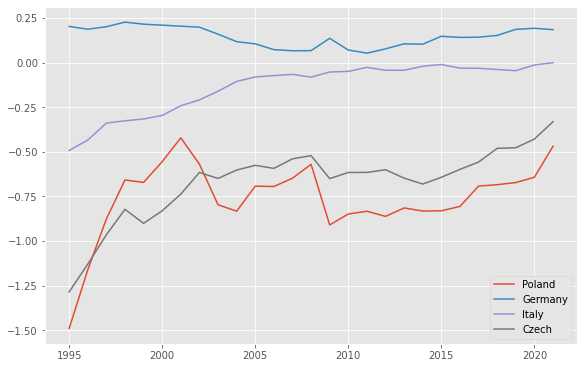

In [17]:
rulc_plot = rulc[rulc['nace_r2'] == 'C'].groupby('country_code')

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(rulc_plot.get_group('PL')['year'], rulc_plot.get_group('PL')['rulc'], label='Poland')
    ax.plot(rulc_plot.get_group('DE')['year'], rulc_plot.get_group('DE')['rulc'], label='Germany')
    ax.plot(rulc_plot.get_group('IT')['year'], rulc_plot.get_group('IT')['rulc'], label='Italy')
    ax.plot(rulc_plot.get_group('CZ')['year'], rulc_plot.get_group('CZ')['rulc'], label='Czech')

    ax.legend()

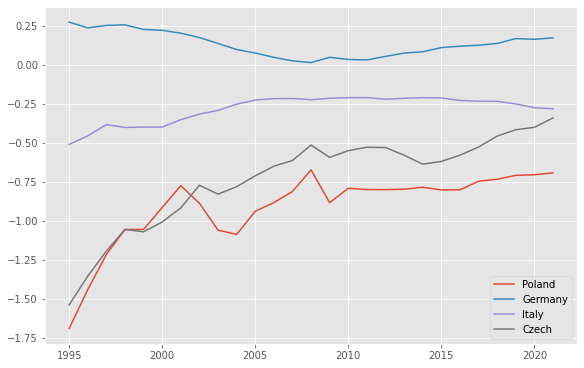

In [18]:
rulc_plot = rulc[rulc['nace_r2'] == 'TOTAL'].groupby('country_code')

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(rulc_plot.get_group('PL')['year'], rulc_plot.get_group('PL')['rulc'], label='Poland')
    ax.plot(rulc_plot.get_group('DE')['year'], rulc_plot.get_group('DE')['rulc'], label='Germany')
    ax.plot(rulc_plot.get_group('IT')['year'], rulc_plot.get_group('IT')['rulc'], label='Italy')
    ax.plot(rulc_plot.get_group('CZ')['year'], rulc_plot.get_group('CZ')['rulc'], label='Czech')

    ax.legend()

In [19]:

def calculate_log_change_nace(df, nace, year1, year2, var):
    # Filter the DataFrame for the specified years
    df = df[df['nace_r2'] == nace]
    df_year1 = df[df['year'] == year1]
    df_year2 = df[df['year'] == year2]

    # Merge the two filtered DataFrames on 'country' to align the values for the same country
    merged_df = pd.merge(df_year1, df_year2, on='country_code', suffixes=('_'+str(year1), '_'+str(year2)))

    # Calculate the ratio and create a new column for it
    merged_df[f'{var}_change'] = merged_df[f'{var}_{year2}'] - merged_df[f'{var}_{year1}']

    return merged_df[['country_code', f'{var}_{year1}', f'{var}_{year2}', f'{var}_change']]




In [20]:
# RULC changes between years 2007 and 2021 = this is my LHS variable
# TODO: think through when different countries entered the EA
rulc_change_07_19 = calculate_log_change_nace(rulc, 'TOTAL', 2007, 2019, 'rulc')
rulc_change_07_19

,country_code,rulc_2007,rulc_2019,rulc_change
0,AT,-0.022783,0.099939,0.122722
1,BE,0.117019,0.113492,-0.003527
2,BG,-1.365071,-0.630974,0.734096
3,CY,-0.188000,-0.232190,-0.044191
4,CZ,-0.614410,-0.417274,0.197136
5,DE,0.023846,0.166744,0.142899
6,DK,0.402107,0.333825,-0.068282
7,EA,0.000000,0.000000,0.000000
8,EE,-0.542287,-0.130830,0.411457
9,EL,-0.344452,-0.532575,-0.188122


In [21]:
rulc_change_07_21 = calculate_log_change_nace(rulc, 'TOTAL', 2007, 2021, 'rulc')
rulc_change_07_21

,country_code,rulc_2007,rulc_2021,rulc_change
0,AT,-0.022783,0.129496,0.152279
1,BE,0.117019,0.085838,-0.031181
2,BG,-1.365071,-0.506563,0.858508
3,CY,-0.188000,-0.277612,-0.089612
4,CZ,-0.614410,-0.341866,0.272544
5,DE,0.023846,0.171629,0.147783
6,DK,0.402107,0.306888,-0.095219
7,EA,0.000000,0.000000,0.000000
8,EE,-0.542287,-0.107665,0.434622
9,EL,-0.344452,-0.555946,-0.211494


### Decomposition - Solow residuals/TFP

In [22]:
# TODO: check the data sources!!!! (especially K!)
def get_solow_residuals(df, tradability = False):
    # Productivity - TFP via Sollow residuals, some notes: https://www.wiwi.hu-berlin.de/de/professuren/vwl/wtm2/forschung/burdasevergnini-2014.pdf
    # Using the Tornquish specification:

    alpha = 0.33
    for col in ['VA_real', 'K', 'L']:
        df[f'log_{col}'] = np.log(df[col])

        if tradability:
            df[f'log_diff_{col}'] = df.groupby(['country_code', 'nace_r2'])[f'log_{col}'].diff()
        else:
            df[f'log_diff_{col}'] = df.groupby(['country_code', 'tradable'])[f'log_{col}'].diff()


    # Törnqvist specification:
    df['A'] = df["log_diff_VA_real"] - (alpha*df["log_diff_K"] + (1-alpha)*df["log_diff_L"])
    #return df[['country_code', 'year', 'EA', 'nace_r2', 'tradable', 'K', 'L', 'VA_real','A']]
    return df

In [44]:
def get_solow_residuals(df, tradability = False):
    # Productivity - TFP via Sollow residuals, some notes: https://www.wiwi.hu-berlin.de/de/professuren/vwl/wtm2/forschung/burdasevergnini-2014.pdf
    # Using the Tornquish specification:

    if tradability:
        df = df.groupby(['country_code', 'year', 'tradable'])[['VA_real', 'K', 'L']].sum().reset_index()

    alpha = 0.33 # TODO: check
    for col in ['VA_real', 'K', 'L']:
        df[f'log_{col}'] = np.log(df[col])

        if tradability:
            df[f'log_diff_{col}'] = df.groupby(['country_code', 'tradable'])[f'log_{col}'].diff()
        else:
            df[f'log_diff_{col}'] = df.groupby(['country_code', 'nace_r2'])[f'log_{col}'].diff()


    # Törnqvist specification:
    df['A'] = df["log_diff_VA_real"] - (alpha*df["log_diff_K"] + (1-alpha)*df["log_diff_L"])
    return df

In [11]:
def is_in_eurozone(row, ea):
    members = ea.get_eurozone_members(row['year'])
    if members is not None and row['country_code'] in members:
        return True
    else:
        return False


def is_tradable(row):
        if row['nace_r2'] in tradable_sectors:
            return True
        elif row['nace_r2'] in non_tradable_sectors:
            return False
        else: return None

In [45]:
# TODO: using EA averages here as nama_10_nfa_st does not contain EA agg, use avg.for ULC itself!!
tfp_df = nama_df[["country_code", "year", "VA_real", "nace_r2"]]
tfp_df = tfp_df.merge(nama_10_nfa_st, on=['country_code', 'year', 'nace_r2'])
tfp_df = tfp_df.merge(nama_10_nfa_e, on=['country_code', 'year', 'nace_r2'])

#tfp_df = tfp_df[tfp_df['nace_r2'] == 'C'] # NOTE: very important, now I concentrate on manufacturing only
tfp_df['EA'] = tfp_df.apply(lambda x: is_in_eurozone(x, ea=eurozone), axis=1)
tfp_df['tradable'] = tfp_df.apply(lambda x: is_tradable(x), axis=1)
tfp_df = tfp_df[~tfp_df['nace_r2'].str.contains('\d')] # Filtering too detailed NACE categories

tfp_nace = get_solow_residuals(tfp_df)
tfp_T = get_solow_residuals(tfp_df, tradability=True)
tfp_nace

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,country_code,year,VA_real,nace_r2,unit_x,asset10,K,unit_y,L,EA,tradable,log_VA_real,log_diff_VA_real,log_K,log_diff_K,log_L,log_diff_L,A
0,AT,1995,29.177416,A,CRC_MNAC,N11N,24305.7,THS_PER,273.10,False,None,3.373395,NaN,10.098466,NaN,5.609838,NaN,NaN
4,AT,1995,7.095607,B,CRC_MNAC,N11N,1626.8,THS_PER,8.65,False,True,1.959476,NaN,7.394370,NaN,2.157559,NaN,NaN
5,AT,1995,397.493720,B-E,CRC_MNAC,N11N,92153.0,THS_PER,737.93,False,None,5.985179,NaN,11.431206,NaN,6.603849,NaN,NaN
6,AT,1995,321.486632,C,CRC_MNAC,N11N,53956.0,THS_PER,673.31,False,True,5.772956,NaN,10.895924,NaN,6.512206,NaN,NaN
31,AT,1995,46.608815,D,CRC_MNAC,N11N,19352.4,THS_PER,30.13,False,None,3.841790,NaN,9.870572,NaN,3.405521,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38625,UK,2021,NaN,Q,CRC_MNAC,N11N,NaN,THS_PER,NaN,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38628,UK,2021,NaN,R,CRC_MNAC,N11N,NaN,THS_PER,NaN,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38631,UK,2021,NaN,S,CRC_MNAC,N11N,NaN,THS_PER,NaN,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38635,UK,2021,NaN,T,CRC_MNAC,N11N,NaN,THS_PER,NaN,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# TODO: this is rough adjustment consider both K and L, should allow for simple summation - consider tfp_df.groupby(['EA', 'year'])[["K", "L"]].sum() + combine with VA from nama_df
tfp_nace_ea = tfp_nace.groupby(['EA', 'year', 'nace_r2'])[["A"]].mean().reset_index() # A^*
tfp_nace_ea = tfp_nace_ea[tfp_nace_ea['EA'] == True]

tfp_T['EA'] = tfp_T.apply(lambda x: is_in_eurozone(x, ea=eurozone), axis=1)
tfp_T_ea = tfp_T.groupby(['EA', 'year', 'tradable'])['A'].mean().reset_index()
tfp_T_ea = tfp_T_ea[tfp_T_ea['EA'] == True]


In [25]:
r_tfp = tfp_nace.merge(tfp_nace_ea, on=['year', 'nace_r2'], suffixes=['', '_ea'])
r_tfp['rel_A'] = r_tfp['A'] - r_tfp['A_ea']

# TODO how did the nace_r2 disappear2
#r_tfp = r_tfp[r_tfp['nace_r2'] == 'C']
prod_change_07_19 = calculate_log_change_nace(r_tfp, 'TOTAL', 2007, 2019, 'rel_A')
prod_change_07_19


,country_code,rel_A_2007,rel_A_2019,rel_A_change
0,AT,-0.010784,-0.006924,0.003860
1,BE,-0.005826,0.002936,0.008762
2,BG,-0.059853,-0.011715,0.048138
3,CY,0.002596,0.022604,0.020007
4,CZ,0.011690,-0.005573,-0.017263
5,DE,0.008634,-0.023868,-0.032502
6,DK,-0.021539,-0.008644,0.012895
7,EE,-0.066254,-0.005911,0.060343
8,EL,-0.046231,0.013928,0.060159
9,ES,-0.004470,0.001146,0.005616


In [60]:
def calculate_log_change_T(df, tradable, year1, year2, var):
    # Filter the DataFrame for the specified years
    df = df.loc[df['tradable'] == tradable]
    
    df_year1 = df[df['year'] == year1]
    df_year2 = df[df['year'] == year2]

    # Merge the two filtered DataFrames on 'country' to align the values for the same country
    merged_df = pd.merge(df_year1, df_year2, on='country_code', suffixes=('_'+str(year1), '_'+str(year2)))

    # Calculate the ratio and create a new column for it
    suff = 'T' if tradable else 'N'
    merged_df[f'{var}_change_{suff}'] = merged_df[f'{var}_{year2}'] - merged_df[f'{var}_{year1}']

    return merged_df[['country_code', f'{var}_{year1}', f'{var}_{year2}', f'{var}_change_{suff}']]


In [63]:
# Balassa-Samuelson version
# NOTE: using similar logic to RULC applied separately to tradable and non-tradable, TODO: check!!!!!!!!!
r_tfp_T = tfp_T.merge(tfp_T_ea, on=['year', 'tradable'], suffixes=['', '_ea'])
r_tfp_T['rel_A'] = r_tfp_T['A'] - r_tfp_T['A_ea']


prod_change_07_19_T = calculate_log_change_T(r_tfp_T, True, 2007, 2019, 'rel_A')
prod_change_07_19_T = prod_change_07_19_T.merge(calculate_log_change_T(r_tfp_T, False, 2007, 2019, 'rel_A'), on='country_code')

prod_change_07_19_T


,country_code,rel_A_2007_x,rel_A_2019_x,rel_A_change_T,rel_A_2007_y,rel_A_2019_y,rel_A_change_N
0,AT,-0.008245,-0.007806,0.000439,-0.015272,-0.006519,0.008753
1,BE,-0.013484,0.013268,0.026752,0.000136,0.000323,0.000187
2,BG,NaN,NaN,NaN,NaN,NaN,NaN
3,CZ,0.014330,0.009425,-0.004905,0.056941,-0.013627,-0.070567
4,DE,0.010902,-0.026859,-0.037761,-0.015896,-0.002913,0.012982
5,DK,-0.034845,0.005425,0.040271,-0.032975,-0.016439,0.016535
6,EE,-0.054758,0.028292,0.083050,-0.131193,-0.042275,0.088919
7,EL,-0.024297,0.006060,0.030357,-0.130775,-0.002203,0.128573
8,ES,-0.019219,-0.007639,0.011581,-0.034738,-0.001381,0.033357
9,FI,0.044581,-0.010628,-0.055209,0.052312,-0.021996,-0.074307


In [ ]:
# Productivity - TFP via Sollow residuals, some notes: https://www.wiwi.hu-berlin.de/de/professuren/vwl/wtm2/forschung/burdasevergnini-2014.pdf
# Using the Tornquish specification:


### Nominal exchange rate

In [92]:
def calculate_log_change(df, year1, year2, var):
    # Filter the DataFrame for the specified years
    df_year1 = df[df['year'] == year1]
    df_year2 = df[df['year'] == year2]

    # Merge the two filtered DataFrames on 'country' to align the values for the same country
    merged_df = pd.merge(df_year1, df_year2, on='country_code', suffixes=('_'+str(year1), '_'+str(year2)))

    # Calculate the ratio and create a new column for it
    merged_df[f'{var}_change'] = merged_df[f'{var}_{year2}'] - merged_df[f'{var}_{year1}']
    merged_df[f'{var}_log_change'] = np.log(merged_df[f'{var}_{year2}']) - np.log(merged_df[f'{var}_{year1}'])

    return merged_df[['country_code', f'{var}_{year1}', f'{var}_{year2}', f'{var}_change', f'{var}_log_change']]

In [93]:
# NOTE: this is already relative to EUZN
e_change_07_19 =  calculate_log_change(ert_bil_eur_a, 2007, 2019, 'ER')
e_change_07_19

,country_code,ER_2007,ER_2019,ER_change,ER_log_change
0,BG,1.95580,1.95580,0.00000,0.000000
1,CZ,27.76600,25.67000,-2.09600,-0.078489
2,DK,7.45060,7.46610,0.01550,0.002078
3,UK,0.68434,0.87777,0.19343,0.248930
4,HU,251.35000,325.30000,73.95000,0.257901
5,PL,3.78370,4.29760,0.51390,0.127354
6,RO,3.33530,4.74530,1.41000,0.352592
7,SE,9.25010,10.58910,1.33900,0.135191


### Markups alias profits shares = competition effect

In [ ]:

# Piton's \mu
# markups = profit share and could be defined as a residual of labor and capital share. See in 3.5_ga_agg, l. 91-96
#PS = 1 - LS - CS 
# Piton: pg.6 profit share = residual after subtracting labor and capital share
# TODO: check!!!!
# For more for EU-KLEMS itself, check the documentation: https://euklems.eu/wp-content/uploads/2023/01/wiiw-GPD_Release2023.pdf

In [202]:
profit_df = nama_df[["country_code", "nace_r2", "year", "COMP", "VA_CP", "EA"]]
profit_df['LS'] = profit_df['COMP'] / profit_df['VA_CP']
profit_df

/var/folders/jv/49b_7nv12xd7_mts18ps53ym0000gn/T/ipykernel_82690/61117920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df['LS'] = profit_df['COMP'] / profit_df['VA_CP']


,country_code,nace_r2,year,COMP,VA_CP,EA,LS
0,AT,A,1995,363.7,3812.3,False,0.095402
1,AT,A01,1995,188.2,2933.0,False,0.064166
2,AT,A02,1995,174.8,873.7,False,0.200069
3,AT,A03,1995,0.7,5.5,False,0.127273
4,AT,B,1995,332.1,543.5,False,0.611040
...,...,...,...,...,...,...,...
67792,UK,S94,2021,NaN,NaN,False,NaN
67793,UK,S95,2021,NaN,NaN,False,NaN
67794,UK,S96,2021,NaN,NaN,False,NaN
67795,UK,T,2021,NaN,NaN,False,NaN


In [203]:
# Capital share, defined as capital compensations over value added (vCS=100*vCAP/vVA) by Piton (see code)
# Capital compesations are the product of capital stocks and user costs of capital (A2.1) 
# User costs of capital depends on investment prices and depreciation rates
# Depreciation rates - defined in 2.1.2 in https://euklems.eu/wp-content/uploads/2023/01/wiiw-GPD_Release2023.pdf
# TODO: see: A2.1 to complete - I just pick a number for now.
profit_df['CS']= 0.2

/var/folders/jv/49b_7nv12xd7_mts18ps53ym0000gn/T/ipykernel_82690/577700047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df['CS']= 0.2


In [204]:
profit_df['markups'] = profit_df.eval('1 - LS - CS')

/var/folders/jv/49b_7nv12xd7_mts18ps53ym0000gn/T/ipykernel_82690/3938784483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df['markups'] = profit_df.eval('1 - LS - CS')


In [205]:
profit_ea = profit_df.groupby(['EA', 'year', 'nace_r2'])[["markups"]].mean().reset_index() # A^*
profit_ea = profit_ea[profit_ea['EA'] == True]
profit_ea


,EA,year,nace_r2,markups
2430,True,1999,A,0.617215
2431,True,1999,A01,0.638743
2432,True,1999,A02,0.430272
2433,True,1999,A03,0.458137
2434,True,1999,B,0.306656
...,...,...,...,...
4495,True,2021,S94,-0.090433
4496,True,2021,S95,0.290673
4497,True,2021,S96,0.410773
4498,True,2021,T,-0.255686


In [207]:
r_profit = profit_df.merge(profit_ea, on=['year', 'nace_r2'], suffixes=['', '_ea'])
r_profit['rel_markups'] = r_profit['markups'] - r_profit['markups_ea']

markups_change_07_19 = calculate_log_change_nace(r_profit, 'TOTAL', 2007, 2019, 'rel_markups')

In [209]:
r_profit

,country_code,nace_r2,year,COMP,VA_CP,EA,LS,CS,markups,EA_ea,markups_ea,rel_markups
0,AT,A,1999,398.4,3510.8,True,0.113478,0.2,0.686522,True,0.617215,0.069307
1,BE,A,1999,241.4,2607.8,True,0.092568,0.2,0.707432,True,0.617215,0.090217
2,BG,A,1999,326.6,3245.2,False,0.100641,0.2,0.699359,True,0.617215,0.082144
3,CY,A,1999,44.4,379.4,False,0.117027,0.2,0.682973,True,0.617215,0.065758
4,CZ,A,1999,33012.0,72492.0,False,0.455388,0.2,0.344612,True,0.617215,-0.272603
...,...,...,...,...,...,...,...,...,...,...,...,...
57748,RO,TOTAL,2021,449335.8,1074748.2,False,0.418085,0.2,0.381915,True,0.264283,0.117632
57749,SE,TOTAL,2021,2571434.0,4872894.0,False,0.527702,0.2,0.272298,True,0.264283,0.008015
57750,SI,TOTAL,2021,27556.3,45897.5,True,0.600388,0.2,0.199612,True,0.264283,-0.064671
57751,SK,TOTAL,2021,43385.1,89465.4,True,0.484937,0.2,0.315063,True,0.264283,0.050780


### User cost of capital

In [ ]:
# this is U_t in Piton + input into markups
# vUC in 3.
# "Constructed via the standard Hall and Jorgenson (1967) formula"

### Decomposition - Simple

In [64]:
# NOTE: simple
# Conection all factor in a single df
decomp_df = rulc_change_07_19.merge(prod_change_07_19, on='country_code')
#decomp_df = decomp_df.merge(markups_change_07_19, on='country_code')

# Simple decomposition (my section 3.1) uses rel_A_change directly
decomp_df['resid_simple'] = decomp_df['rulc_change'] - decomp_df['rel_A_change']


In [115]:
# TODO: transfer eq. (22) here - or something, check how Piton actually does this
decomp_df = rulc_change_07_19.merge(prod_change_07_19_T, on='country_code')
decomp_df = decomp_df.merge(e_change_07_19, on='country_code', how='left')
decomp_df['ER_change'] = decomp_df['ER_log_change'].fillna(0)
decomp_df = get_regions(decomp_df,  'country_code')
decomp_df = get_emu_regions(decomp_df, 'country_code')

# Piton 2021 RPROD from eq.22
gamma = 0.5
decomp_df['RPROD_change']  = gamma*(decomp_df['rel_A_change_T'] - decomp_df['rel_A_change_N']) # NOTE: these are change in between 2007 and 2019
decomp_df['resid'] = decomp_df['rulc_change'] - decomp_df['RPROD_change']

decomp_df[['country_code', 'region', 'rulc_change', 'RPROD_change', 'ER_change','resid']]

,country_code,region,rulc_change,RPROD_change,ER_change,resid
0,AT,DE_AT,0.122722,-0.004157,0.000000,0.126879
1,BE,west,-0.003527,0.013283,0.000000,-0.016809
2,BG,balkan,0.734096,NaN,0.000000,NaN
3,CZ,visegrad,0.197136,0.032831,-0.078489,0.164305
4,DE,DE_AT,0.142899,-0.025371,0.000000,0.168270
5,DK,north,-0.068282,0.011868,0.002078,-0.080150
6,EE,CEE_non_core,0.411457,-0.002934,0.000000,0.414392
7,EL,rest,-0.188122,-0.049108,0.000000,-0.139015
8,ES,south,-0.131756,-0.010888,0.000000,-0.120868
9,FI,north,0.122500,0.009549,0.000000,0.112951


In [117]:
# NOTE: comparison purposes - Piton weights her group average by GDP in Euros
decomp_plot = decomp_df[['country_code', 'region', 'emu_region', 'rulc_change', 'RPROD_change', 'ER_change','resid']]
decomp_plot.groupby('region').mean()


,rulc_change,RPROD_change,ER_change,resid
region,,,,
CEE_non_core,0.242853,0.013724,0.000000,0.229129
DE_AT,0.132810,-0.014764,0.000000,0.147574
balkan,0.600776,0.086123,0.176296,0.381332
north,0.054448,0.007673,0.045756,0.046775
rest,0.018714,-0.071164,0.000000,0.089878
south,-0.069695,-0.010099,0.000000,-0.059596
visegrad,0.148394,-0.007048,0.076692,0.155443
west,0.020831,0.006620,0.049786,0.047504


In [119]:
decomp_plot.groupby('emu_region').mean()


,rulc_change,RPROD_change,ER_change,resid
emu_region,,,,
core,0.071170,-0.000954,0.000000,0.072124
non_emu,0.189394,-0.003164,0.080427,0.170470
periphery,0.024130,0.000651,0.000000,0.023479


In [ ]:
# Piton bar plot

### Specifications

- Spec1: primary one, using maximum amount of data+max countries
- Spec2: "sanity check" no.1 - following Piton 2021
- Spec3: 2007-2019, easiest given the Eurostat data
- Spec4: non Balassa-Samuelson

### Balassa - Samuelson inspired decomposition

### TODOs

- Check data sources compare with lit.
- Double check calculation
- Create t
- Data downloads to a separate file
- Filter the countries (note that `country_code` assignment for ert_bil_eur_a could create distortin otherwise, all countries apart from the list are marked as EA)
- EA NAMA_10_NFA_ST does not have the aggregate units for EA, only the individual countries - will use average - TODO unify
- Tradability